## Attention implementation in PyTorch 

<b>Author</b>: Ruthvik G.

## Description

PyTorch implementation of Attention from [Bahdanau's](https://arxiv.org/abs/1409.0473) Neural Machine Translation by Jointly Learning to Align and Translate.

Implentation and Problem Statement credits: Tal Baumel's excellent and insightful [DyNet implementation](https://talbaumel.github.io/blog/attention/). Some of the helper functions are directly taken from the blog and most of them are derived from his blogpost.

Align class implementation from [AuCson's](https://github.com/AuCson/PyTorch-Batch-Attention-Seq2seq/blob/master/attentionRNN.py) github repo.

I took this as an exercise to strengthen my PyTorch's API understanding and the working of Attention(Align and Translate) model.

## Toy dataset generation

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import choice, randrange

SOS = "<SOS>" # Start of Sentence token
EOS = "<EOS>" # End of Sentence token
characters = list("abcd")
characters.append(EOS)
characters.append(SOS)

# dictionaries for vocab indexing
int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)

# function that generates word(length between min_length and max_length).
def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)
    random_char_list = [choice(characters[:-2]) for _ in range(random_length)]
    random_string = ''.join(random_char_list) 
    return random_string, random_string[::-1]

In [3]:
print(sample_model(6, 8))

('dcaccdc', 'cdccacd')


In [4]:
MAX_STRING_LEN = 15

# generate training and validation data
train_data = [sample_model(1, MAX_STRING_LEN) for _ in range(4000)]
valid_data = [sample_model(1, MAX_STRING_LEN) for _ in range(50)]

In [5]:
# add eos and sos tokens to the words generated 
def _add_eos_tokenize(string):
    string = [SOS] + list(string) + [EOS]
    return [char2int[c] for c in string]

## Import all the required torch modules

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim

## Simple RNN Model

A simple RNN model. The RNN used in single directional LSTM. [nn.LSTM](https://pytorch.org/docs/master/nn.html#torch.nn.LSTM) from PyTorch.

Key Points:

* *inputs_size* here is *embedding_dim*.
* Tried only random initialization for hidden states. 
* Returns raw scores not probabilities.

In [17]:
class SimpleRNN(nn.Module):
    
    def __init__(self, num_layers=2, inputs_size=15, hidden_size=20):
        super(SimpleRNN, self).__init__()
        
        self.num_layers = num_layers
        self.inputs_size = inputs_size
        self.hidden_size = hidden_size
        
        # embedding_layer
        self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE,
                                      embedding_dim=inputs_size)
        # lstm_layer
        self.rnn = nn.LSTM(input_size=inputs_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=False) # bidirectional=False (default setting)
        # linear_layer
        self.linear = nn.Linear(in_features=hidden_size, 
                               out_features=VOCAB_SIZE)
        
    # method to initialize the hidden and context values of the lstm_layer
    def _initialize_hidden(self):
        return (torch.randn(self.num_layers, 1, self.hidden_size), torch.randn(self.num_layers, 1, self.hidden_size))
    
    # forward propagate the inputs through the network 
    def forward(self, inputs):
        
        input_embeddings = self.embedding(inputs)
        rnn_inputs = torch.unsqueeze(input_embeddings, 1) # add the batch_size dimension
        
        hidden = self._initialize_hidden()
        rnn_out, _ = self.rnn(rnn_inputs, hidden)
        
        lin_in = torch.squeeze(rnn_out, 1) # remove the batch_size dimension
        out = self.linear(lin_in)
        return out

## Define the loss function.

* Used CrossEntropy loss. ([nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss))

In [7]:
criterion = nn.CrossEntropyLoss()

## Import some more libraries

In [8]:
from tqdm import tqdm
import math

## Helper functions from train/eval of the model.

* Predict function 
* count_matches to calculate the accuracy
* TODO: pass learning_rate as a parameter to the train function.

### Optimizer

* Used SGD optimizer. [optim.SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)
* Adam wasn't converging properly. (Try to reason this.)

In [9]:
def predict(model, sample):

    pdc = model(torch.LongTensor(_add_eos_tokenize(sample)))
    
    pdc = list(torch.argmax(pdc, 1))
    pred_str = ''
    for i in pdc[1:-1]:
        pred_str = pred_str + int2char[i]
    return pred_str

def count_matches(model, val_set):
    matches = [predict(model, input_string)==output_string for input_string, output_string in val_set]
    return matches.count(True)

def train(model, train_data, valid_data, n_epochs=20):
    
    def get_val_loss(model, valid_data):
        
        loss = [criterion(model(torch.LongTensor(_add_eos_tokenize(valid_sample[0]))), torch.LongTensor(_add_eos_tokenize(valid_sample[1]))) for valid_sample in valid_data]
        return sum(loss)
    
    # Define optimizer and adjust the learning rate
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    n_iter = 0
    losses = []
    iterations = []
    
    for epoch in range(1, n_epochs+1):
        epoch_loss = 0
        for i, training_sample in enumerate(train_data):
            
            # initialize the training
            model.train()
            optimizer.zero_grad() # set all the gradients to zero
            
            n_iter += 1
            predictions = model(torch.LongTensor(_add_eos_tokenize(training_sample[0])))
            
            loss = criterion(predictions, torch.LongTensor(_add_eos_tokenize(training_sample[1])))
            epoch_loss += loss.item()
            
            # back propagate through network
            loss.backward()
            optimizer.step() # optimizer step to update the gradients
            
            # calculate the validation loss for every 100 iterations
            if n_iter%100==0:
                
                model.eval()
                val_loss = get_val_loss(model, valid_data)
                
                losses.append(val_loss)
                iterations.append(n_iter)
        
        # save the model(only paramaters not the whole model)
        torch.save(model.state_dict(), "./pretrained/string_reversal_{}".format(model.__class__.__name__))
    
    plt.plot(iterations, losses)
    plt.show()
    print("Loss on validation dataset: {}".format(val_loss))

#### Train the model

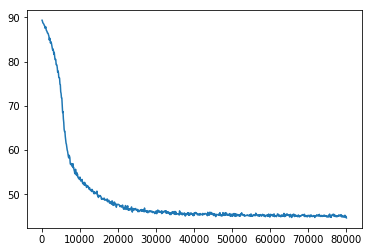

Loss on validation dataset: 44.66676712036133


In [21]:
model = SimpleRNN()
train(model, train_data=train_data, valid_data=valid_data)

In [22]:
short_strings = [sample_model(1, 5) for _ in range(100)]
medium_strings = [sample_model(5, 10) for _ in range(100)]
long_strings = [sample_model(10, 15) for _ in range(100)]

print('Matches for short strings', count_matches(model, short_strings))
print('Matches for medium strings', count_matches(model, medium_strings))
print('Matches for long strings', count_matches(model, long_strings))

Matches for short strings 32
Matches for medium strings 0
Matches for long strings 0


## Bidirectional RNN Model

A birectional RNN model. The RNN used in  bidirectional LSTM. [nn.LSTM](https://pytorch.org/docs/master/nn.html#torch.nn.LSTM) from PyTorch.

Key Points:
* *inputs_size* here is *embedding_dim*.
* Tried only random initialization for hidden states. 
* Concatenated the inputs of the LSTM.
    * Try averaging.

In [23]:
class BidirectionalRNN(nn.Module):
    
    def __init__(self, num_layers=2, inputs_size=15, hidden_size=20):
        super(BidirectionalRNN, self).__init__()
        
        self.num_layers = num_layers
        self.inputs_size = inputs_size
        self.hidden_size = hidden_size
        
        # embedding_layer
        self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE,
                                      embedding_dim=inputs_size)
        # lstm_layer
        self.rnn = nn.LSTM(input_size=inputs_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=False,
                          bidirectional=True)                      # birectional = True
        # linear_layer
        self.linear = nn.Linear(in_features=2*self.hidden_size,    # inputs are concatenated values of both lstms
                               out_features=VOCAB_SIZE)
    
    # initialize the hidden and context values of the lstm
    def _initialize_hidden(self):
        return (torch.randn(2*self.num_layers, 1, self.hidden_size), torch.randn(2*self.num_layers, 1, self.hidden_size))
    
    # forward propagate through the network
    def forward(self, inputs):
        
        input_embeddings = self.embedding(inputs)
        rnn_inputs = torch.unsqueeze(input_embeddings, 1)
        
        hidden = self._initialize_hidden()
        rnn_out, _ = self.rnn(rnn_inputs, hidden)
        
        lin_in = torch.squeeze(rnn_out, 1)
        out = self.linear(lin_in)
        
        return out

#### Train the model

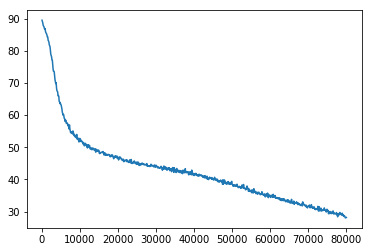

Loss on validation dataset: 28.195648193359375


In [24]:
bidirec_model = BidirectionalRNN()
train(bidirec_model, train_data=train_data, valid_data=valid_data)

### Helper functions 

To better understand the learned capabilities of the models.

In [25]:
short_strings = [sample_model(1, 5) for _ in range(100)]
medium_strings = [sample_model(5, 10) for _ in range(100)]
long_strings = [sample_model(10, 15) for _ in range(100)]

print('Matches for short strings', count_matches(bidirec_model, short_strings))
print('Matches for medium strings', count_matches(bidirec_model, medium_strings))
print('Matches for long strings', count_matches(bidirec_model, long_strings))

Matches for short strings 72
Matches for medium strings 3
Matches for long strings 0


## Encoder Decoder Model

A Encoder-Decoder architecture. The RNN used in  bidirectional LSTM. [nn.LSTM](https://pytorch.org/docs/master/nn.html#torch.nn.LSTM) from PyTorch. The encoder module encodes the whole input sequence into a fixed length vector. The decoder takes this encoded vector concatenated with input embeddings and outputs the predicted sequence.

Key Points:
* *inputs_size* here is *embedding_dim*.
* Tried only random initialization for hidden states. 
* Passed encoder output concatenated input embeddings at every timestep of the decoder LSTM. 
* Try these other methods:
    * Concat the encoder ouput previous input embedding.
    * Pass only the encoder output at every time step.
    * Add the context_size parameter to the network module.

In [10]:
class EncoderRNN(nn.Module):
    
    def __init__(self, num_layers=2, inputs_size=15, hidden_size=20):
        super(EncoderRNN, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # embedding_layer
        self.embed = nn.Embedding(num_embeddings=VOCAB_SIZE, 
                                  embedding_dim=inputs_size)
        # lstm_layer
        self.rnn = nn.LSTM(input_size=inputs_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=False,
                           bidirectional=False)
    
    # initialize the hidden and context values of the lstm
    def _initialize_hidden(self):
        return (torch.randn(self.num_layers, 1, self.hidden_size), torch.randn(self.num_layers, 1, self.hidden_size))
    
    # forward propagate through the encoder
    def forward(self, inputs):
        
        input_embeddings = self.embed(inputs)
        rnn_inputs = torch.unsqueeze(input_embeddings, 1)
        
        hidden = self._initialize_hidden()
        output, _ = self.rnn(rnn_inputs, hidden)
        
        return output[-1, :, :] # take only the output of the final time step.
    
class DecoderRNN(nn.Module):
    
    def __init__(self, num_layers=2, inputs_size=15, hidden_size=20):
        super(DecoderRNN, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.context_size = hidden_size
        self.inputs_size = inputs_size
        
        # embedding_layer
        self.embed = nn.Embedding(num_embeddings=VOCAB_SIZE, 
                                  embedding_dim=inputs_size)
        # lstm_layer
        self.rnn = nn.LSTM(input_size=inputs_size + self.context_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=False,
                           bidirectional=False)
        # linear_layer
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=VOCAB_SIZE)
        
    # initialize the hidden and context values of the lstm
    def _initialize_hidden(self):
        return (torch.randn(self.num_layers, 1, self.hidden_size), torch.randn(self.num_layers, 1, self.hidden_size))
        
    # forward propagate through the network
    def forward(self, inputs, context):
            
        input_embeddings = self.embed(inputs)
        # concat the input embeddings at every timestep
        rnn_inputs = torch.cat((input_embeddings, context.repeat(inputs.shape[0], 1)), 1)
        rnn_inputs = torch.unsqueeze(rnn_inputs, 1)

        hidden = self._initialize_hidden()
        rnn_out, _ = self.rnn(rnn_inputs, hidden)

        rnn_out = torch.squeeze(rnn_out, 1)
        out = self.linear(rnn_out)

        return out

In [11]:
class EncoderDecoderRNN(nn.Module):
    
    def __init__(self, en_layers=2, de_layers=2, inputs_size=15, hidden_size=20):
        super(EncoderDecoderRNN, self).__init__()
        
        self.encoder = EncoderRNN(num_layers=en_layers,
                                  inputs_size=inputs_size,
                                  hidden_size=hidden_size)
        self.decoder = DecoderRNN(num_layers=de_layers,
                                  inputs_size=inputs_size,
                                  hidden_size=hidden_size)
        
    def forward(self, inputs):
        
        context = self.encoder(inputs)
        out = self.decoder(inputs, context)
        
        return out

#### Train the model

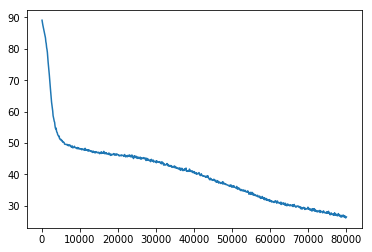

Loss on validation dataset: 26.399871826171875


In [13]:
seq2seq_model = EncoderDecoderRNN(en_layers=1, de_layers=1, inputs_size=4, hidden_size=32)
train(seq2seq_model, train_data=train_data, valid_data=valid_data)

#### Evaluate the model

In [14]:
short_strings = [sample_model(1, 5) for _ in range(100)]
medium_strings = [sample_model(5, 10) for _ in range(100)]
long_strings = [sample_model(10, 15) for _ in range(100)]

print('Matches for short strings', count_matches(seq2seq_model, short_strings))
print('Matches for medium strings', count_matches(seq2seq_model, medium_strings))
print('Matches for long strings', count_matches(seq2seq_model, long_strings))

Matches for short strings 79
Matches for medium strings 3
Matches for long strings 0


In [15]:
predict(seq2seq_model, 'cbcca')

'acccc'

## Attention Model

Align and Translate architecture from [Bahdanau's paper](https://arxiv.org/pdf/1409.0473.pdf). The RNN used in  bidirectional LSTM. [nn.LSTM](https://pytorch.org/docs/master/nn.html#torch.nn.LSTM) from PyTorch. The encoder module is same as the one used in seq2seq model.

Key Points:
* *inputs_size* here is *embedding_dim*.
* Tried only random initialization for hidden states.
* Decoder module is for one time step. Need to interate it through the sequence length of the input
* Passed encoder output alone at every timestep of the decoder LSTM. 
* Try these other methods:
    * Concat the encoder ouput previous input embedding.
    * Pass only the encoder output at every time step.
    * Add the context_size parameter to the network module.
    * Use bidirectional RNN.

In [16]:
class EncoderRNN(nn.Module):
    
    def __init__(self, num_layers=2, inputs_size=15, hidden_size=20):
        super(EncoderRNN, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # embedding_layer
        self.embed = nn.Embedding(num_embeddings=VOCAB_SIZE, 
                                  embedding_dim=inputs_size)
        # lstm_layer
        self.rnn = nn.LSTM(input_size=inputs_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=False,
                           bidirectional=False)
    
    # initialize the hidden and context values of lstm layer
    def _initialize_hidden(self):
        return (torch.randn(self.num_layers, 1, self.hidden_size), torch.randn(self.num_layers, 1, self.hidden_size))
    
    # forward propagate through the network
    def forward(self, inputs):
        
        input_embeddings = self.embed(inputs)
        rnn_inputs = torch.unsqueeze(input_embeddings, 1)
        
        hidden = self._initialize_hidden()
        output, _ = self.rnn(rnn_inputs, hidden)
        
        return output

### Attention Module

* e_matrix has the weighted scores of the encoder outputs.
* torch.bmm for Batch Matrix Multiplication.
* Simply concatenated encoder output and hidden state. Can add a weight parameter between their addition.

In [17]:
class Align(nn.Module):
    def __init__(self, hidden_size):
        super(Align, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size*2, hidden_size)
        
        # weight parameter for e scores with normal initialization
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1./ math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        
    def forward(self, hidden, encoder_out):
        
        # get the sequence length
        max_len = encoder_out.size(0)
        H= hidden[-1, :, :].unsqueeze(0).repeat(max_len, 1, 1).transpose(0, 1) # taje only the ouptputs of the final layer
        encoder_out = encoder_out.transpose(0, 1)
        
        # get raw scores as e_matrix and pass to the softmax function
        e_matrix = self.get_alpha_matrix(H, encoder_out)
        return F.softmax(e_matrix, dim=1).unsqueeze(1)
        
    def get_alpha_matrix(self, hidden, encoder_out):
        
        # tanh non-linearity after concatenating encoder outputs and hidden state
        e_align = F.tanh(self.attn(torch.cat([encoder_out, hidden], 2)))
        
        e_align = e_align.transpose(2, 1)
        v = self.v.repeat(encoder_out.size(0), 1).unsqueeze(1)
        # batch matrix multiply v and alignment scores
        e_align = torch.bmm(v, e_align)
        
        return e_align.squeeze(1)

In [18]:
class AttentionDecoder(nn.Module):
    def __init__(self, num_layers=2, inputs_size=15, hidden_size=20):
        super(AttentionDecoder, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.context_size = hidden_size
        self.inputs_size = inputs_size
        
        # embedding_layer
        self.embed = nn.Embedding(num_embeddings=VOCAB_SIZE, 
                                  embedding_dim=inputs_size)
        
        # lstm_layer
        self.rnn = nn.LSTM(input_size=self.context_size, # Add self.input_size for adding input embeddings 
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=False,
                           bidirectional=False)
        # alignment_layer
        self.align = Align(hidden_size = self.hidden_size)
        # linear_layer
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=VOCAB_SIZE)
    
    # initialize only the context values of the lstm
    def _init_context_lstm(self):
        return torch.randn(self.num_layers, 1, self.hidden_size)
        
    def forward(self, inputs, prev_hidden, encoder_out, context_lstm):
        
        in_embed = self.embed(inputs)
        in_embed = in_embed.unsqueeze(1)
        
        attn_w = self.align(prev_hidden, encoder_out)
        context = attn_w.bmm(encoder_out.transpose(0, 1))
        context = context.transpose(0, 1)
        
        #context_lstm = self._init_context_lstm()
        #rnn_in = torch.cat([in_embed, context], 2)
        
        rnn_in = context
        # pass the previous hidden layer to the lstm
        rnn_out, (current_hidden, curr_context) = self.rnn(rnn_in, (prev_hidden, context_lstm))
        
        return self.linear(rnn_out.squeeze(1)), attn_w, rnn_out, (current_hidden, curr_context)

In [19]:
class AttnNetwork(nn.Module):
    def __init__(self, en_layers=2, de_layers=2, inputs_size=15, hidden_size=20):
        super(AttnNetwork, self).__init__()
        
        self.inputs_size = inputs_size
        self.hidden_size = hidden_size
        self.de_layers = de_layers
        
        self.encoder = EncoderRNN(num_layers=en_layers,
                                  inputs_size=self.inputs_size,
                                  hidden_size=self.hidden_size)
        self.decoder = AttentionDecoder(num_layers=de_layers,
                                        inputs_size=self.inputs_size,
                                        hidden_size=self.hidden_size)
        
    def forward(self, inputs):
        
        encoder_out = self.encoder(inputs)
        max_len = encoder_out.size(0)
        
        out = torch.zeros([max_len, VOCAB_SIZE])
        hidden = torch.rand([self.de_layers, 1, self.hidden_size])
        in_ = torch.LongTensor([5])
        
        # iterate through the input sequence length
        lstm_context = self.decoder._init_context_lstm()
        for i in range(max_len):
            
            out_, attn_w, rnn_out, (hidden, lstm_context) = self.decoder(in_, hidden, encoder_out, lstm_context)
            out[i] = out_
            in_ = torch.argmax(out_, 1)
        
        return out

#### Train the model

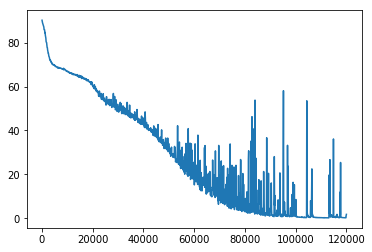

Loss on validation dataset: 1.8603354692459106


In [ ]:
attn_model = AttnNetwork(en_layers=1, de_layers=1, inputs_size=4, hidden_size=32)
train(attn_model, train_data=train_data, valid_data=valid_data, n_epochs=30)

#### Load a saved model

In [21]:
# Uncomment these lines to load a saved model 

attn_model = AttnNetwork(en_layers=1, de_layers=1, inputs_size=4, hidden_size=32)
attn_model.load_state_dict(torch.load('./string_reversal_attn'))

### Evaluate the model

In [22]:
short_strings = [sample_model(1, 5) for _ in range(100)]
medium_strings = [sample_model(5, 10) for _ in range(100)]
long_strings = [sample_model(10, 15) for _ in range(100)]

print('Matches for short strings', count_matches(attn_model, short_strings))
print('Matches for medium strings', count_matches(attn_model, medium_strings))
print('Matches for long strings', count_matches(attn_model, long_strings))

Matches for short strings 99
Matches for medium strings 100
Matches for long strings 100
